In [76]:
from pathlib import Path
import pandas as pd
import regex as re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Experiment on Local Mode

## Independent Variable
* ```ncores: [4, 8, 16, 32]```
* ```workload: [daa, dpp]```
* ```node: [gl6]```

## Dependent Variable:

* ```Energy Consumption (MJ)```
* ```Execution Time (hours)```
* ```Memory Utilization - AveRSS (MB)```

In [77]:
# Functions for parsing the files
def extract_workflow(df):
    # This function gets the entries referring to batches
    # and extracts the corresponding workflow from the job entry
    batches = df[df['JobID'].str.contains('batch', regex=True)]

    for i, row in batches.iterrows():
        jobid = row.JobID.split('.')[0]  # extracts di ID
        # find the job entry in the dataframe including all the entries
        jobrow = df[df['JobID'] == jobid]
        # extract the workflow from job name
        workflow = jobrow['JobName'].item().split('-')[0]

        # substitute JobName with the workflow
        row['JobName'] = workflow
        row['JobID'] = jobid

    return batches.rename(columns={'JobName': 'Workflow'})


def parse(path):
    df = pd.read_csv(path, header=None, delimiter=r"\s+")
    df.columns = list(df.loc[0])  # set headers
    # gets completed entries
    df = df[(df['State'] == 'COMPLETED')]

    return extract_workflow(df)


def read_dataset(files):
    dfs = [parse(f) for f in files]

    return pd.concat(dfs, ignore_index=True)

In [78]:
# Functions for performing Statistical Tests
import scipy.stats as stats
from scipy.stats import f_oneway
from scipy.stats import shapiro
from statistics import mean

pd.set_option('mode.chained_assignment', None)


def improvement(original_value, new_value):
    improvement_percentage = ((new_value - original_value) / abs(original_value)) * 100
    return improvement_percentage


# Code taken from
# https://stats.stackexchange.com/questions/67926/understanding-the-one-way-anova-effect-size-in-scipy

def effect_size(*args):
    """ Return the eta squared as the effect size for ANOVA"""
    return float(ss_between(*args) / ss_total(*args))


def ss_total(*args):
    vec = concentrate(*args)
    ss_total = sum((vec - np.mean(vec)) ** 2)

    return ss_total


def ss_between(*args):
    # grand mean
    grand_mean = np.mean(concentrate(*args))

    ss_btwn = 0
    for a in args:
        ss_btwn += (len(a) * (np.mean(a) - grand_mean) ** 2)

    return ss_btwn


def ss_within(*args):
    return ss_total(*args) - ss_between(*args)


def concentrate(*args):
    v = list(map(np.asarray, args))
    vec = np.hstack(np.concatenate(v))
    return vec


def normality_check(samples, x_label="", y_label=""):
    # Set Grid for the plots
    fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20, 10))

    c = 0
    i = 0

    # Normality Check using Shapiro-Wilk
    for x, y in samples.items():
        stat, p = shapiro(y)
        print('NCORES:', x, '\tSTAT:', stat, '\tp-value:', p)

        # Generate a Violin Plot
        ax = sns.violinplot(data=y, ax=axs[i][c])
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.set_xticklabels([x])
        c += 1

        if c > 1:
            i += 1
            c = 0

In [79]:
# Import Dataset
data_dir = "./exp-local/data/old"

## RQ - What is the impact of the ncores parameter on energy consumption and performance?

In [80]:
files = Path(data_dir).glob('*gl6*.txt')
data = read_dataset(files)

In [81]:
data.head()

,JobID,Workflow,Cluster,NodeList,State,Start,End,ConsumedEnergy,AveRSS,AveDiskRead,AveDiskWrite,AveVMSize,Elapsed,NCPUS
0,42964,daa,gl2_gl4,gl6,COMPLETED,2023-11-25T03:30:50,2023-11-25T09:21:34,3.15M,4874676K,88378.66M,12751.54M,102386892K,05:50:44,16
1,42967,daa,gl2_gl4,gl6,COMPLETED,2023-11-25T09:26:37,2023-11-25T14:02:59,2.69M,9481496K,88354.41M,12748.31M,201854440K,04:36:22,32
2,42970,dpp,gl2_gl4,gl6,COMPLETED,2023-11-25T14:08:03,2023-11-25T15:20:30,511.62K,657888K,5345.22M,804.96M,26437380K,01:12:27,4
3,42973,daa,gl2_gl4,gl6,COMPLETED,2023-11-25T15:25:35,2023-11-25T21:16:11,3.17M,4883076K,88354.44M,12748.31M,102385240K,05:50:36,16
4,42976,dpp,gl2_gl4,gl6,COMPLETED,2023-11-25T21:21:16,2023-11-25T21:47:14,222.22K,2199092K,5345.23M,804.97M,98673080K,00:25:58,16


In [82]:
def convert_to_hours(time_str):
    d = 0

    if '-' in time_str:
        d = time_str.split('-')
        time_str = d[1]
        d = int(d[0])

    h, m, s = list(map(int, time_str.split(':')))
    total_hours = h + m / 60 + s / 3600

    return total_hours + (d * 24)


def remove_unit(string):
    if 'M' in string:
        return string.replace('M', '')
    # elif 'K' in string:
    return string.replace('K', '')


def convert_to_gb(memory_str):
    return float(remove_unit(memory_str)) * (10 ** -6)


def convert_to_mega_joule(energy_str):
    return remove_unit(energy_str)


def get_data(data, workflow="daa", column="Elapsed"):
    output = data[data['Workflow'] == workflow][[column, 'NCPUS']]

    # Clean Data
    if column == "ConsumedEnergy":
        output[column] = output[column].apply(convert_to_mega_joule)
    elif column == "AveRSS":
        output[column] = output[column].apply(convert_to_gb)
    elif column == "Elapsed":
        output[column] = output[column].apply(convert_to_hours)

    # Convert Data
    return output.astype({column: float, "NCPUS": int})

### Energy Consumption 

#### DAA

In [83]:
daa_energy = get_data(data, workflow='daa', column='ConsumedEnergy')

In [84]:
# Descriptive Statistics
daa_energy.groupby('NCPUS').agg(['mean', 'std', 'var'])

ConsumedEnergy                    
                mean       std       var
NCPUS                                   
2          12.750000       NaN       NaN
4           7.558000  0.042374  0.001796
8           4.762727  0.054606  0.002982
16          3.192000  0.033928  0.001151
32          2.707000  0.022136  0.000490

In [85]:
# Pearson correlation Between NCORES and Energy Consumption
print(
    "Pearson Correlation:",
    daa_energy['NCPUS'].corr(daa_energy['ConsumedEnergy'])
)

Pearson Correlation: -0.7748707447910639


In [86]:
# Obtaining the samples (daa, 4) (daa, 8) .. (daa, 32)
samples = {
    x: list(daa_energy[daa_energy['NCPUS'] == x]['ConsumedEnergy']) for x in [4, 8, 16, 32]
}

NCORES: 4 	STAT: 0.8624092936515808 	p-value: 0.08146137744188309
NCORES: 8 	STAT: 0.8761255741119385 	p-value: 0.09287411719560623
NCORES: 16 	STAT: 0.8718368411064148 	p-value: 0.10501144826412201


C:\Users\Dmitrijs\AppData\Local\Temp\ipykernel_16840\1174982195.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([x])
C:\Users\Dmitrijs\AppData\Local\Temp\ipykernel_16840\1174982195.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([x])
C:\Users\Dmitrijs\AppData\Local\Temp\ipykernel_16840\1174982195.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([x])
C:\Users\Dmitrijs\AppData\Local\Temp\ipykernel_16840\1174982195.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([x])


NCORES: 32 	STAT: 0.7524783611297607 	p-value: 0.003825535299256444


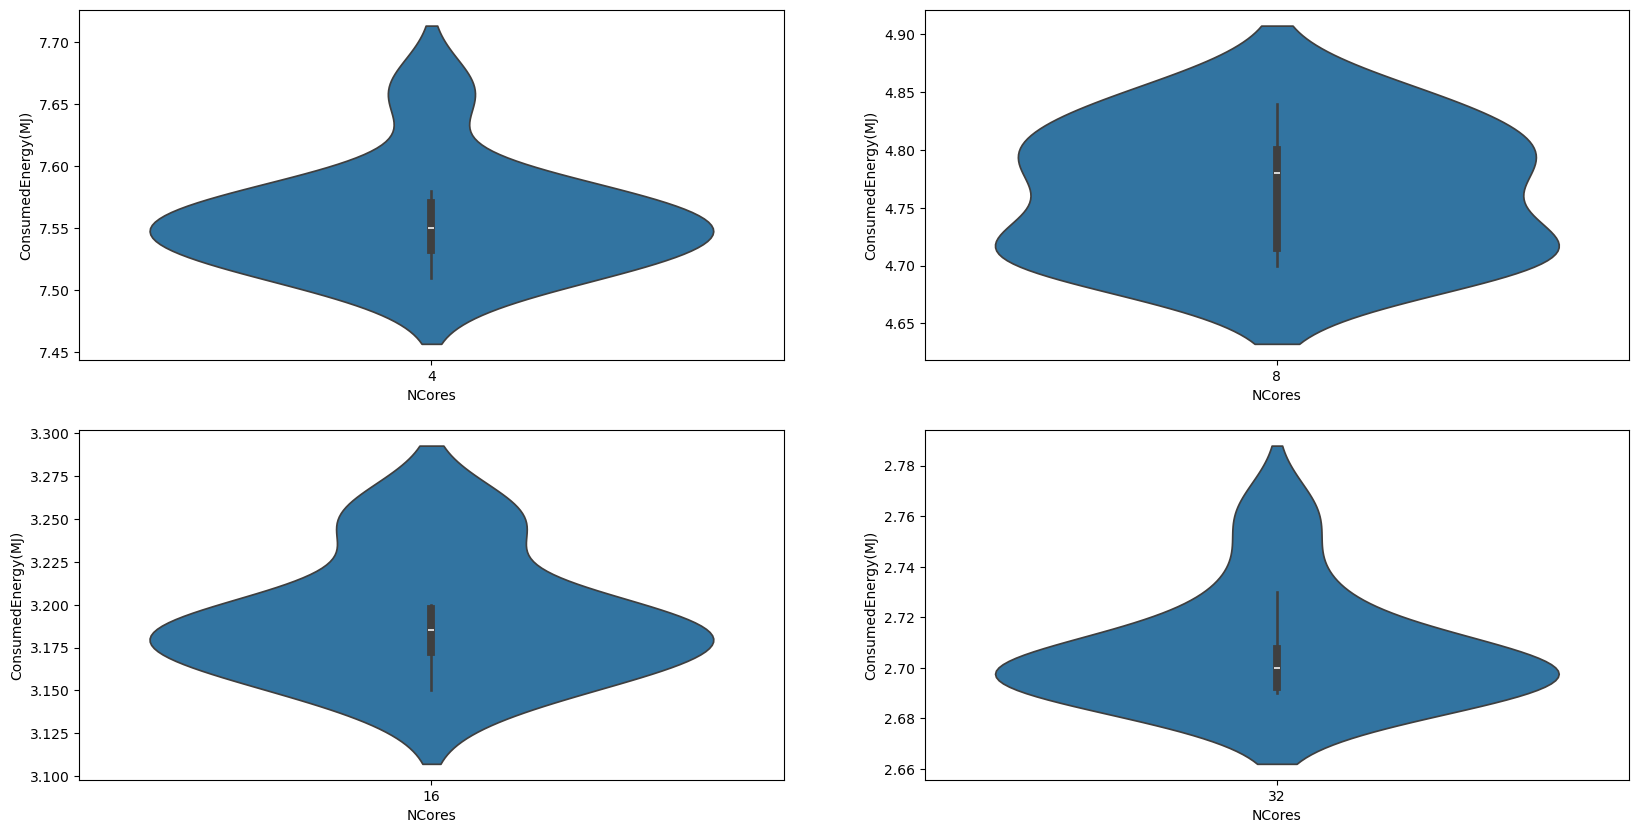

In [87]:
normality_check(samples, x_label='NCores', y_label='ConsumedEnergy(MJ)')

In [88]:
# homoscedasticity Levene's Test
statistic, p_value = stats.levene(*list(samples.values()))
print("stat:", statistic, "p_value:", p_value)

stat: 2.8235537745699277 p_value: 0.05198792258942086


In [89]:
# One-Way Anova Test
f_stat, p_value = f_oneway(*list(samples.values()))
print("f_stat:", statistic, "p_value:", p_value)

f_stat: 2.8235537745699277 p_value: 1.9560856582679797e-62


In [90]:
# Effect Size using Eta Squared
effect_size(*list(samples.values()))

0.99957650009329

In [91]:
# Average Improvement
average_energy = [mean(x) for x in samples.values()]
improvement(average_energy[0], average_energy[-1])

-64.1836464673194

#### DPP

In [92]:
dpp_energy = get_data(data, workflow='dpp', column='ConsumedEnergy')

In [93]:
# Descriptive Statistics
dpp_energy.groupby('NCPUS').agg(['mean', 'std', 'var'])

ConsumedEnergy                     
                mean       std        var
NCPUS                                    
2            826.350       NaN        NaN
4            514.615  4.816701  23.200606
8            323.648  3.644685  13.283729
16           226.368  3.723185  13.862107
32           198.764  2.881991   8.305871

In [94]:
# Pearson correlation Between NCORES and Energy Consumption
print(
    "Pearson Correlation:",
    dpp_energy['NCPUS'].corr(dpp_energy['ConsumedEnergy'])
)

Pearson Correlation: -0.7727246451968414


In [95]:
# Obtaining the samples (daa, 4) (daa, 8) .. (daa, 32)
samples = {
    x: list(dpp_energy[dpp_energy['NCPUS'] == x]['ConsumedEnergy']) for x in [4, 8, 16, 32]
}

NCORES: 4 	STAT: 0.8529692888259888 	p-value: 0.06300633400678635
NCORES: 8 	STAT: 0.8045158982276917 	p-value: 0.01645064540207386
NCORES: 16 	STAT: 0.8855656981468201 	p-value: 0.1510733813047409
NCORES: 32 	STAT: 0.8386011123657227 	p-value: 0.042453259229660034


C:\Users\Dmitrijs\AppData\Local\Temp\ipykernel_16840\1174982195.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([x])
C:\Users\Dmitrijs\AppData\Local\Temp\ipykernel_16840\1174982195.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([x])
C:\Users\Dmitrijs\AppData\Local\Temp\ipykernel_16840\1174982195.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([x])
C:\Users\Dmitrijs\AppData\Local\Temp\ipykernel_16840\1174982195.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([x])


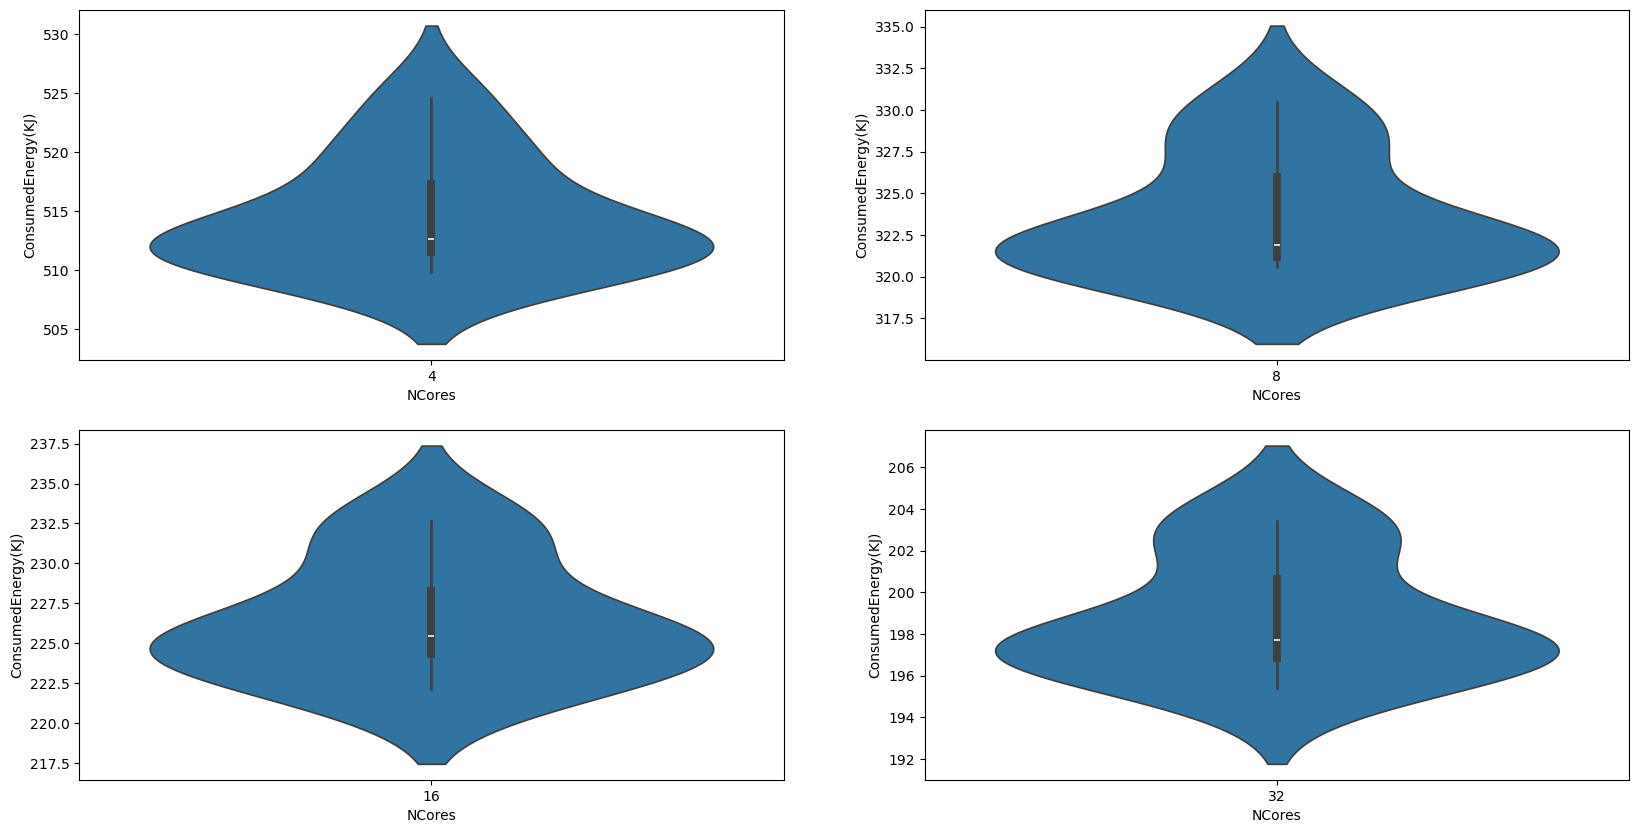

In [96]:
normality_check(samples, x_label='NCores', y_label='ConsumedEnergy(KJ)')

In [97]:
# homoscedasticity Levene's Test
statistic, p_value = stats.levene(*list(samples.values()))
print("stat:", statistic, "p_value:", p_value)

stat: 0.4253910089350368 p_value: 0.7359729086053282


In [98]:
# One-Way Anova Test
f_stat, p_value = f_oneway(*list(samples.values()))
print("f_stat:", statistic, "p_value:", p_value)

f_stat: 0.4253910089350368 p_value: 3.275323339562959e-55


In [99]:
# Effect Size using Eta Squared
effect_size(*list(samples.values()))

0.9991393964601775

In [100]:
# Average Improvement
average_energy = [mean(x) for x in samples.values()]
improvement(average_energy[0], average_energy[-1])

-61.37617442165503

### Execution Time

#### DAA

In [101]:
daa_time = get_data(data, workflow='daa', column='Elapsed')

In [102]:
# Descriptive Statistics
daa_time.groupby('NCPUS').agg(['mean', 'std', 'var'])

Elapsed                    
            mean       std       var
NCPUS                               
2      33.433611       NaN       NaN
4      17.266889  0.096293  0.009272
8       9.921616  0.145312  0.021116
16      5.908861  0.082972  0.006884
32      4.646694  0.065511  0.004292

In [103]:
# Pearson correlation Between NCORES and Execution Time
print(
    "Pearson Correlation:",
    daa_time['NCPUS'].corr(daa_time['Elapsed'])
)

Pearson Correlation: -0.7548649602309248


In [104]:
# Obtaining the samples (daa, 4) (daa, 8) .. (daa, 32)
samples = {
    x: list(daa_time[daa_time['NCPUS'] == x]['Elapsed']) for x in [4, 8, 16, 32]
}

NCORES: 4 	STAT: 0.8794687390327454 	p-value: 0.12867243587970734
NCORES: 8 	STAT: 0.9246911406517029 	p-value: 0.3596668541431427
NCORES: 16 	STAT: 0.8138996958732605 	p-value: 0.021379802376031876
NCORES: 32 	STAT: 0.8761342167854309 	p-value: 0.11777540296316147


C:\Users\Dmitrijs\AppData\Local\Temp\ipykernel_16840\1174982195.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([x])
C:\Users\Dmitrijs\AppData\Local\Temp\ipykernel_16840\1174982195.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([x])
C:\Users\Dmitrijs\AppData\Local\Temp\ipykernel_16840\1174982195.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([x])
C:\Users\Dmitrijs\AppData\Local\Temp\ipykernel_16840\1174982195.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([x])


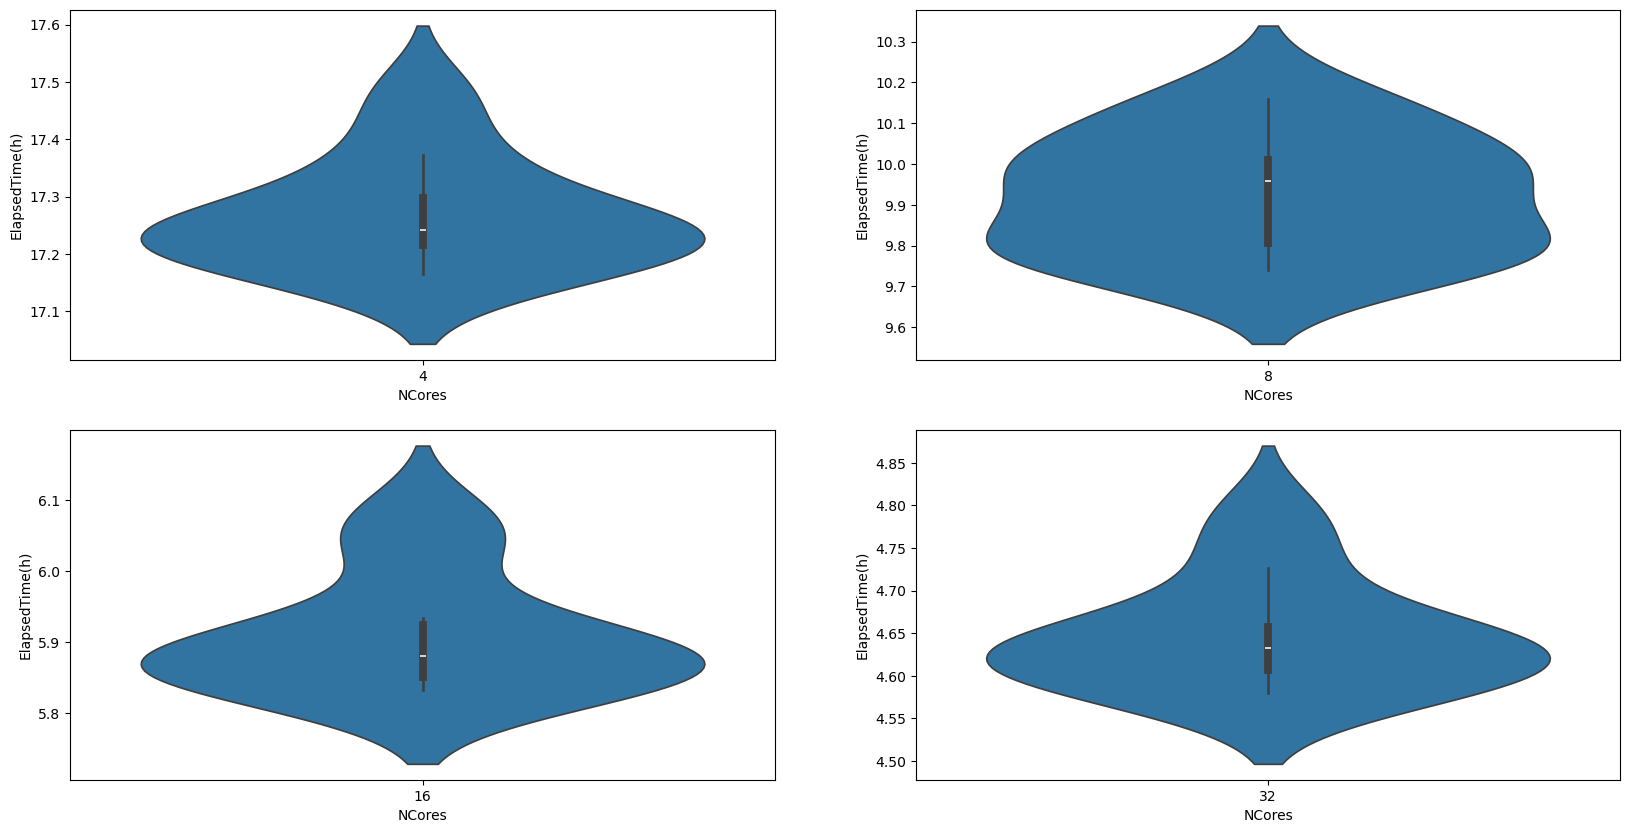

In [105]:
normality_check(samples, x_label='NCores', y_label='ElapsedTime(h)')

In [106]:
# Average Improvement
average_energy = [mean(x) for x in samples.values()]
improvement(average_energy[0], average_energy[-1])

-73.08898855870581

#### DPP

In [107]:
dpp_time = get_data(data, workflow='dpp', column='Elapsed')

In [108]:
# Descriptive Statistics
dpp_time.groupby('NCPUS').agg(['mean', 'std', 'var'])

Elapsed                    
           mean       std       var
NCPUS                              
2      2.351944       NaN       NaN
4      1.218667  0.020588  0.000424
8      0.695611  0.010945  0.000120
16     0.445556  0.014224  0.000202
32     0.358028  0.009067  0.000082

In [109]:
# Pearson correlation Between NCORES and Execution Time
print(
    "Pearson Correlation:",
    dpp_time['NCPUS'].corr(dpp_time['Elapsed'])
)

Pearson Correlation: -0.7471086386840049


In [110]:
samples = {
    x: list(dpp_time[dpp_time['NCPUS'] == x]['Elapsed']) for x in [4, 8, 16, 32]
}

NCORES: 4 	STAT: 0.8233646154403687 	p-value: 0.027829403057694435
NCORES: 8 	STAT: 0.8124135732650757 	p-value: 0.020511379465460777
NCORES: 16 	STAT: 0.8661661744117737 	p-value: 0.09016764909029007
NCORES: 32 	STAT: 0.8841363191604614 	p-value: 0.1455181986093521


C:\Users\Dmitrijs\AppData\Local\Temp\ipykernel_16840\1174982195.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([x])
C:\Users\Dmitrijs\AppData\Local\Temp\ipykernel_16840\1174982195.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([x])
C:\Users\Dmitrijs\AppData\Local\Temp\ipykernel_16840\1174982195.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([x])
C:\Users\Dmitrijs\AppData\Local\Temp\ipykernel_16840\1174982195.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([x])


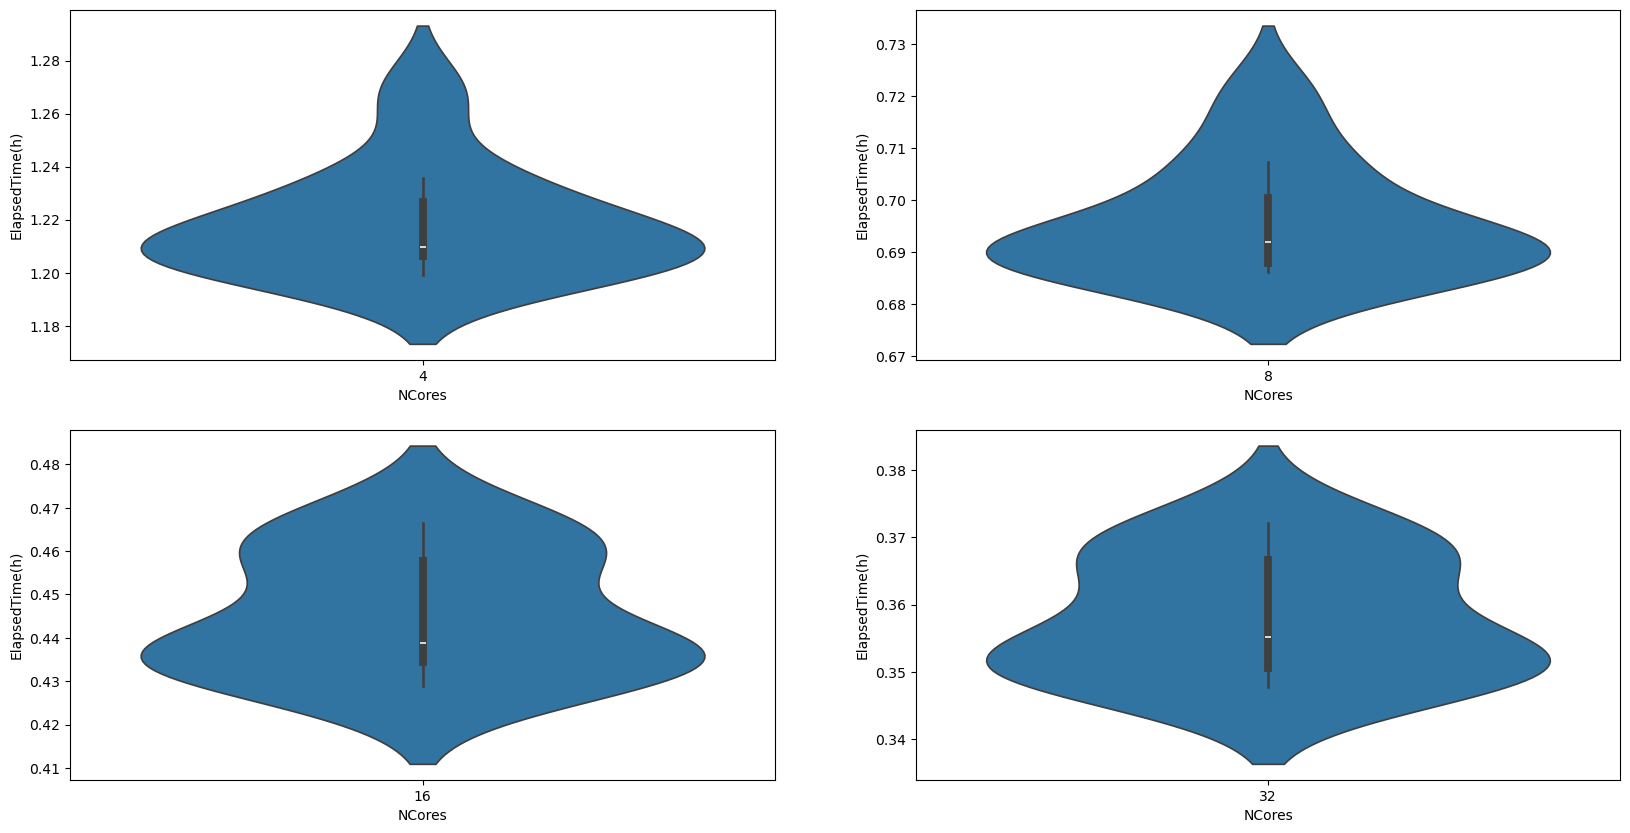

In [111]:
normality_check(samples, x_label='NCores', y_label='ElapsedTime(h)')

In [112]:
# Average Improvement
average_energy = [mean(x) for x in samples.values()]
improvement(average_energy[0], average_energy[-1])

-70.6213530269876

### Memory Usage

#### DAA

In [113]:
daa_memory = get_data(data, workflow='daa', column='AveRSS')

In [114]:
daa_memory.head()

,AveRSS,NCPUS
0,4.874676,16
1,9.481496,32
3,4.883076,16
6,2.608084,8
7,0.889364,2


In [115]:
# Descriptive Statistics
daa_memory.groupby('NCPUS').agg(['mean', 'std', 'var'])

AveRSS                    
           mean       std       var
NCPUS                              
2      0.889364       NaN       NaN
4      1.552179  0.192548  0.037075
8      2.629645  0.078819  0.006212
16     4.878790  0.006286  0.000040
32     9.456919  0.024110  0.000581

In [116]:
# Pearson correlation Between NCORES and Memory
print(
    "Pearson Correlation:",
    daa_memory['NCPUS'].corr(daa_memory['AveRSS'])
)

Pearson Correlation: 0.9994356095199393


In [117]:
samples = {
    x: list(daa_memory[daa_memory['NCPUS'] == x]['AveRSS']) for x in [4, 8, 16, 32]
}

NCORES: 4 	STAT: 0.5314385890960693 	p-value: 8.515804438502528e-06
NCORES: 8 	STAT: 0.4698384404182434 	p-value: 6.587104053323856e-07
NCORES: 16 	STAT: 0.9494577050209045 	p-value: 0.6620887517929077
NCORES: 32 	STAT: 0.8346819877624512 	p-value: 0.03809473291039467


C:\Users\Dmitrijs\AppData\Local\Temp\ipykernel_16840\1174982195.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([x])
C:\Users\Dmitrijs\AppData\Local\Temp\ipykernel_16840\1174982195.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([x])
C:\Users\Dmitrijs\AppData\Local\Temp\ipykernel_16840\1174982195.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([x])
C:\Users\Dmitrijs\AppData\Local\Temp\ipykernel_16840\1174982195.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([x])


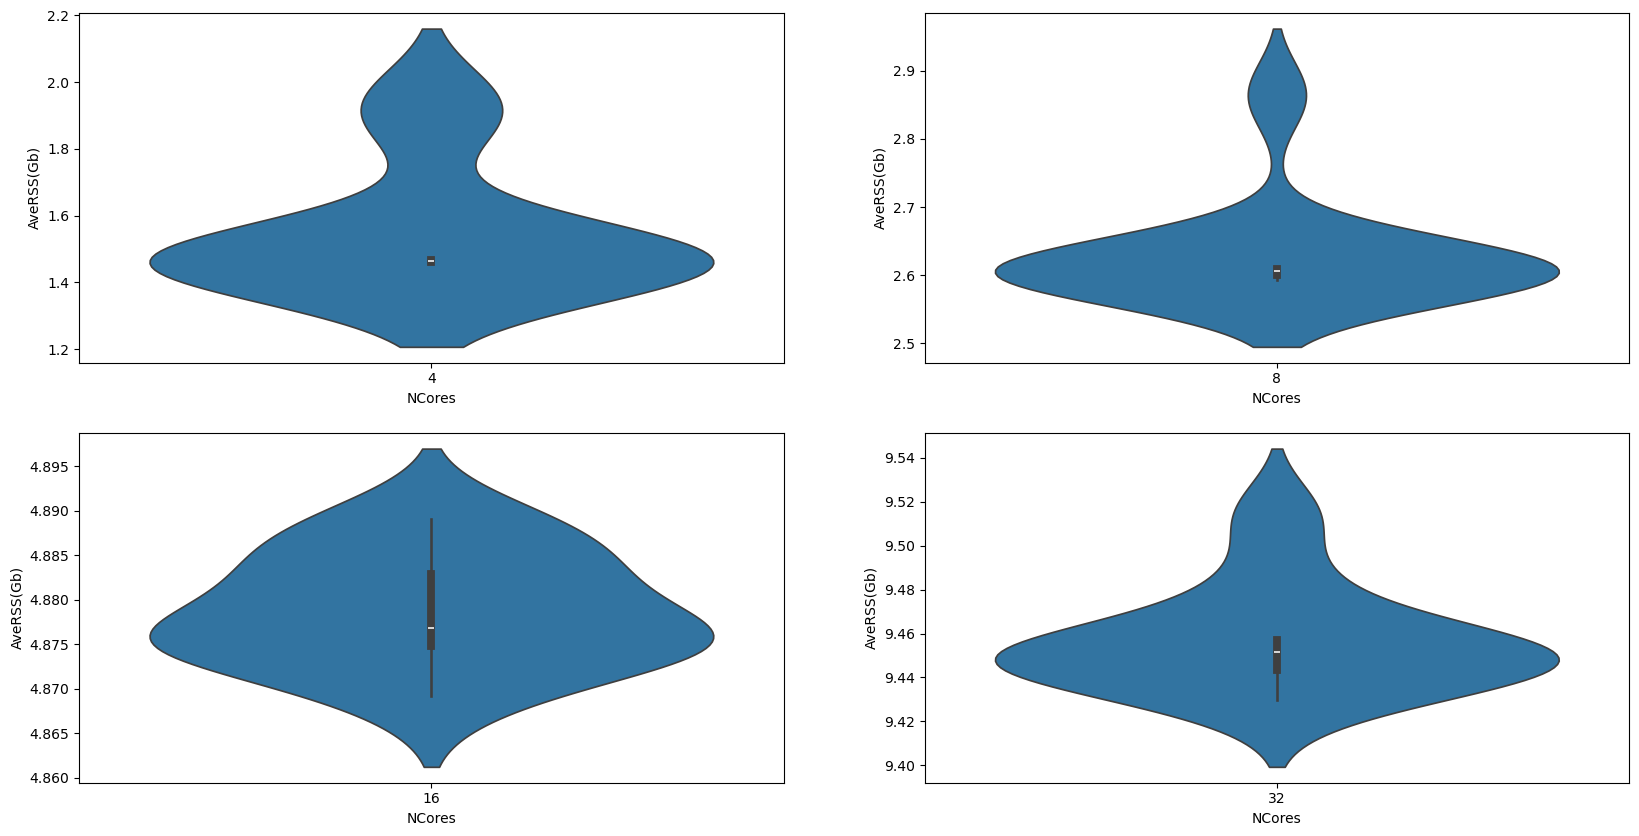

In [118]:
normality_check(samples, x_label='NCores', y_label='AveRSS(Gb)')

In [119]:
# Average Improvement
average_energy = [mean(x) for x in samples.values()]
improvement(average_energy[0], average_energy[-1])

509.2672289385144

#### DPP

In [120]:
dpp_memory = get_data(data, workflow='dpp', column='AveRSS')

In [121]:
dpp_memory.groupby('NCPUS').agg(['mean', 'std', 'var'])

AveRSS                    
           mean       std       var
NCPUS                              
2      0.398680       NaN       NaN
4      0.665799  0.009358  0.000088
8      1.177572  0.010036  0.000101
16     2.197242  0.007307  0.000053
32     3.928931  0.064277  0.004132

In [122]:
# Pearson correlation Between NCORES and Memory
print(
    "Pearson Correlation:",
    dpp_memory['NCPUS'].corr(dpp_memory['AveRSS'])
)

Pearson Correlation: 0.9987382720462704


In [123]:
samples = {
    x: list(dpp_memory[dpp_memory['NCPUS'] == x]['AveRSS']) for x in [4, 8, 16, 32]
}

NCORES: 4 	STAT: 0.8786264061927795 	p-value: 0.12583374977111816


C:\Users\Dmitrijs\AppData\Local\Temp\ipykernel_16840\1174982195.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([x])
C:\Users\Dmitrijs\AppData\Local\Temp\ipykernel_16840\1174982195.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([x])
C:\Users\Dmitrijs\AppData\Local\Temp\ipykernel_16840\1174982195.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([x])
C:\Users\Dmitrijs\AppData\Local\Temp\ipykernel_16840\1174982195.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([x])


NCORES: 8 	STAT: 0.9293909072875977 	p-value: 0.4419277608394623
NCORES: 16 	STAT: 0.9231909513473511 	p-value: 0.3843395709991455
NCORES: 32 	STAT: 0.8746510744094849 	p-value: 0.11321312189102173


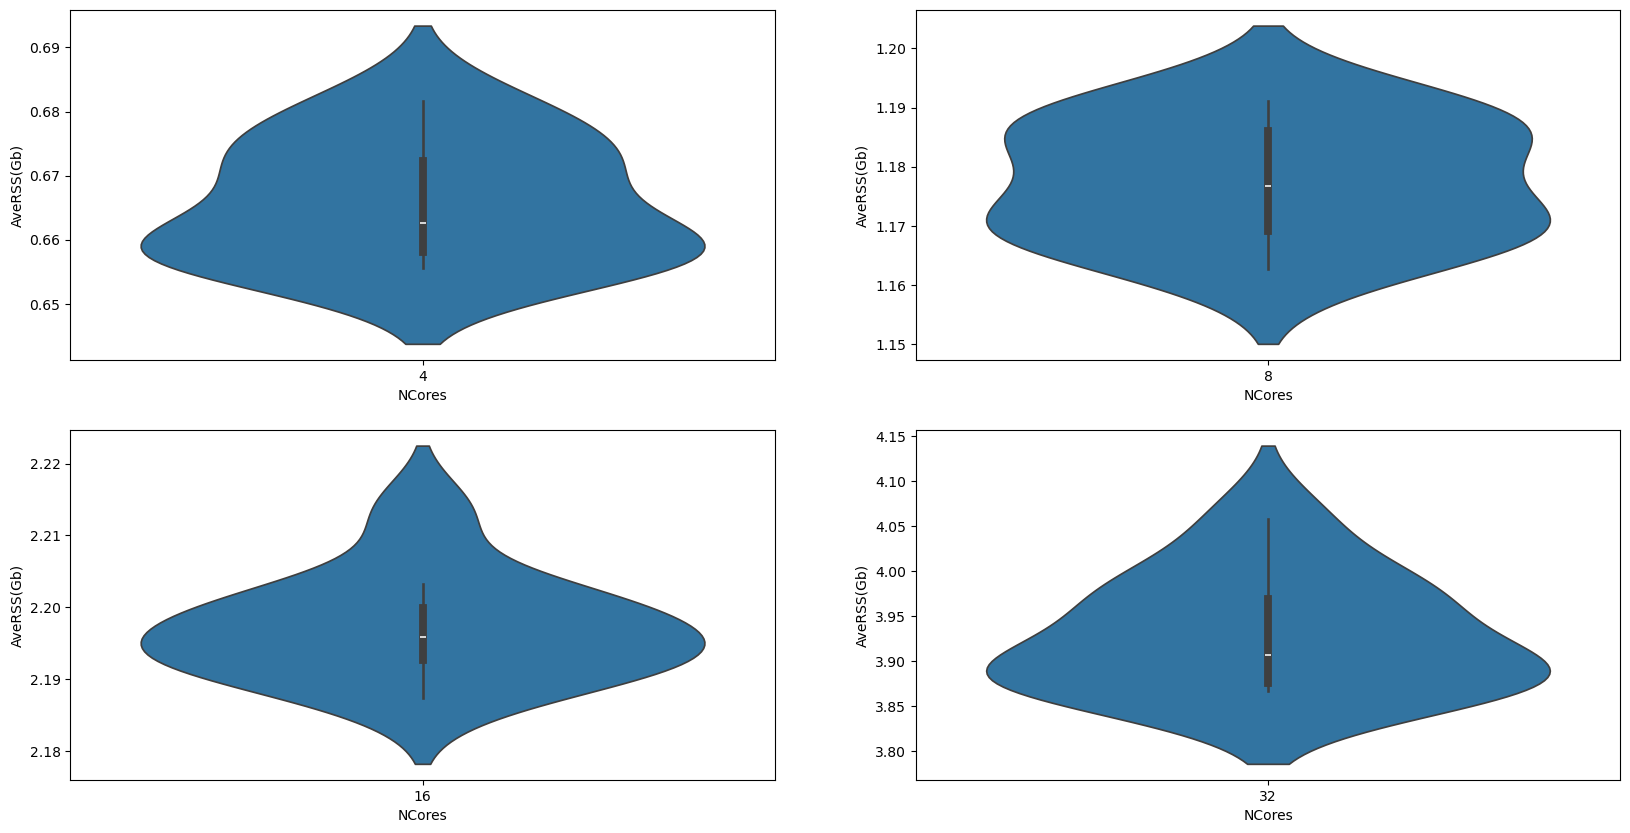

In [124]:
normality_check(samples, x_label='NCores', y_label='AveRSS(Gb)')

In [125]:
# Average Improvement
average_energy = [mean(x) for x in samples.values()]
improvement(average_energy[0], average_energy[-1])

490.10788244136216

In [126]:
data

,JobID,Workflow,Cluster,NodeList,State,Start,End,ConsumedEnergy,AveRSS,AveDiskRead,AveDiskWrite,AveVMSize,Elapsed,NCPUS
0,42964,daa,gl2_gl4,gl6,COMPLETED,2023-11-25T03:30:50,2023-11-25T09:21:34,3.15M,4874676K,88378.66M,12751.54M,102386892K,05:50:44,16
1,42967,daa,gl2_gl4,gl6,COMPLETED,2023-11-25T09:26:37,2023-11-25T14:02:59,2.69M,9481496K,88354.41M,12748.31M,201854440K,04:36:22,32
2,42970,dpp,gl2_gl4,gl6,COMPLETED,2023-11-25T14:08:03,2023-11-25T15:20:30,511.62K,657888K,5345.22M,804.96M,26437380K,01:12:27,4
3,42973,daa,gl2_gl4,gl6,COMPLETED,2023-11-25T15:25:35,2023-11-25T21:16:11,3.17M,4883076K,88354.44M,12748.31M,102385240K,05:50:36,16
4,42976,dpp,gl2_gl4,gl6,COMPLETED,2023-11-25T21:21:16,2023-11-25T21:47:14,222.22K,2199092K,5345.23M,804.97M,98673080K,00:25:58,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,43519,dpp,gl2_gl4,gl6,COMPLETED,2023-12-17T14:54:40,2023-12-17T16:08:26,518.42K,672512K,5341.92M,804.47M,26490624K,01:13:46,4
79,43522,daa,gl2_gl4,gl6,COMPLETED,2023-12-17T16:13:30,2023-12-18T02:20:19,4.84M,2601644K,88378.65M,12751.49M,52564156K,10:06:49,8
80,43525,dpp,gl2_gl4,gl6,COMPLETED,2023-12-18T02:25:23,2023-12-18T02:47:29,203.27K,3874200K,5345.24M,805.05M,193711116K,00:22:06,32
81,44005,dpp,gl2_gl4,gl6,COMPLETED,2023-12-20T16:36:57,2023-12-20T17:52:59,524.61K,658816K,5345.24M,805.04M,26436040K,01:16:02,4


## RQ - What is the impact of the underlying hardware platform on energy consumption and performance?

In [147]:
## merge into a single descriptive table
daa_e = daa_energy.groupby('NCPUS').agg(['mean', 'std', 'var']).reset_index()
dpp_e = dpp_energy.groupby('NCPUS').agg(['mean', 'std', 'var']).reset_index()
daa_t = daa_time.groupby('NCPUS').agg(['mean', 'std', 'var']).reset_index()
dpp_t = dpp_time.groupby('NCPUS').agg(['mean', 'std', 'var']).reset_index()
daa_m = daa_memory.groupby('NCPUS').agg(['mean', 'std', 'var']).reset_index()
dpp_m = dpp_memory.groupby('NCPUS').agg(['mean', 'std', 'var']).reset_index()

# combine all daa
daa = pd.merge(daa_e, daa_t, on='NCPUS')
daa = pd.merge(daa, daa_m, on='NCPUS')

# combine all dpp
dpp = pd.merge(dpp_e, dpp_t, on='NCPUS')
dpp = pd.merge(dpp, dpp_m, on='NCPUS')

# add explicit columns with workflow - either daa or dpp
daa['workflow'] = 'daa'
dpp['workflow'] = 'dpp'

# combine all
all_data = pd.concat([daa, dpp])

# drop NCPUS == 2
all_data = all_data[all_data['NCPUS'] != 2]

# reset index
all_data.reset_index(drop=True, inplace=True)

# show only 3 digits after the comma
all_data = all_data.round(3)

#  make workflow the first column
cols = all_data.columns.tolist()
cols = cols[-1:] + cols[:-1]
all_data = all_data[cols]

all_data

C:\Users\Dmitrijs\AppData\Local\Temp\ipykernel_16840\732581149.py:10: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  daa = pd.merge(daa_e, daa_t, on='NCPUS')
C:\Users\Dmitrijs\AppData\Local\Temp\ipykernel_16840\732581149.py:11: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  daa = pd.merge(daa, daa_m, on='NCPUS')
C:\Users\Dmitrijs\AppData\Local\Temp\ipykernel_16840\732581149.py:14: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  dpp = pd.merge(dpp_e, dpp_t, on='NCPUS')
C:\Users\Dmitrijs\AppData\Local\Temp\ipykernel_16840\732581149.py:15: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  dpp = pd.merge(dpp, dpp_m, on='NCPUS')


workflow NCPUS ConsumedEnergy                Elapsed               AveRSS  \
                           mean    std     var    mean    std    var   mean   
0      daa     4          7.558  0.042   0.002  17.267  0.096  0.009  1.552   
1      daa     8          4.763  0.055   0.003   9.922  0.145  0.021  2.630   
2      daa    16          3.192  0.034   0.001   5.909  0.083  0.007  4.879   
3      daa    32          2.707  0.022   0.000   4.647  0.066  0.004  9.457   
4      dpp     4        514.615  4.817  23.201   1.219  0.021  0.000  0.666   
5      dpp     8        323.648  3.645  13.284   0.696  0.011  0.000  1.178   
6      dpp    16        226.368  3.723  13.862   0.446  0.014  0.000  2.197   
7      dpp    32        198.764  2.882   8.306   0.358  0.009  0.000  3.929   

                 
     std    var  
0  0.193  0.037  
1  0.079  0.006  
2  0.006  0.000  
3  0.024  0.001  
4  0.009  0.000  
5  0.010  0.000  
6  0.007  0.000  
7  0.064  0.004